In [77]:
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

import matplotlib.pyplot as plt

import numpy as np

import random

from typing import Optional

from tkinter import *

import PIL

from PIL import Image, ImageDraw

In [78]:
tf.__version__

'2.16.1'

In [79]:
# keras.__version__

1. Load data

In [80]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [81]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

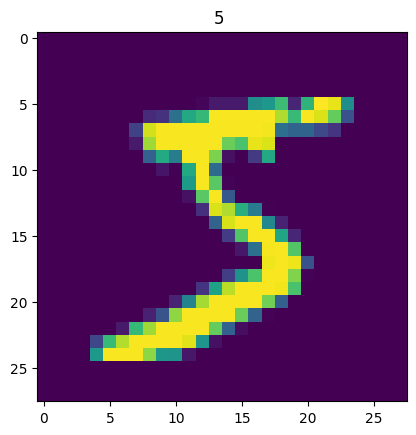

In [82]:
plt.title(f"{y_train[0]} ")
plt.imshow(X_train[0])

In [83]:
class_names = [str(i) for i in range(10)]

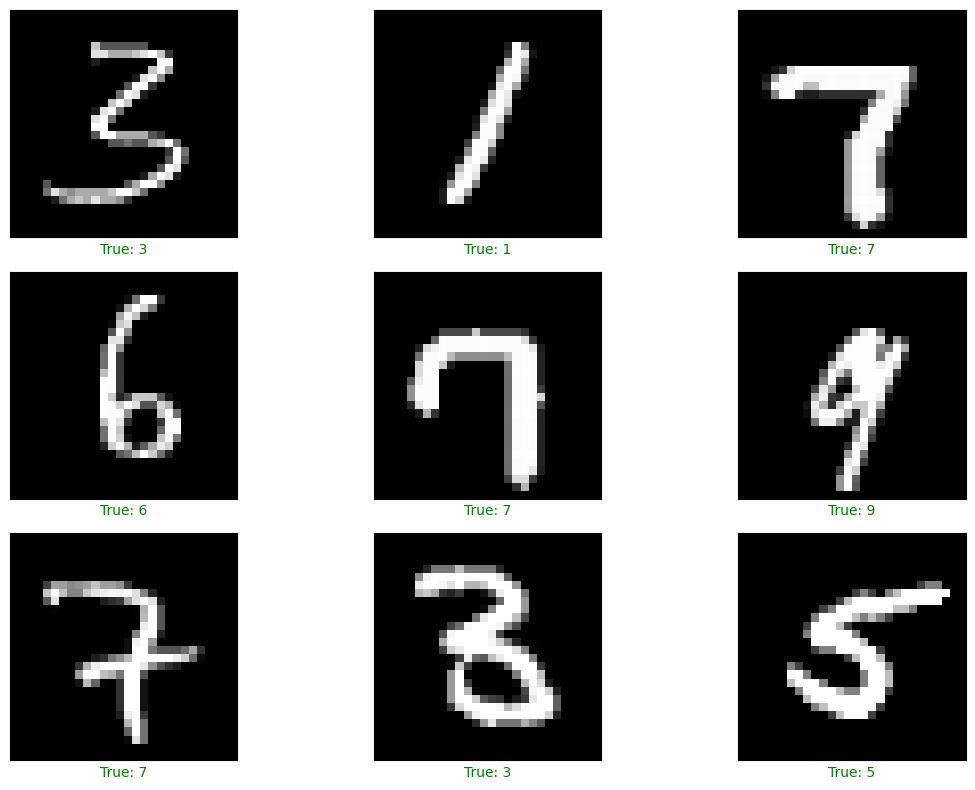

In [84]:
def plot_image(x_data: np.ndarray, y_data: np.ndarray, y_prob: Optional[np.ndarray] = None) -> None:
  rows, cols = 3,3
  fig, axes = plt.subplots(rows,cols,figsize = (12,8))
  x_len = x_data.shape[0]

  for i in range(rows*cols):
    ax = axes[i // rows, i % cols]

    img_idx = random.randint(0,x_len)

    ax.imshow(x_data[img_idx], cmap = 'gray')
    ax.set(xticks=[],yticks=[])

    color = 'green'
    true_label = f"True: {class_names[y_data[img_idx]]}"

    if y_prob is not None:
      predicted_idx = np.argmax(y_prob[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f"\nPredicted: {predicted_label}"

    img_title = true_label if y_prob is None else true_label + predicted_label_str
    ax.set_xlabel(img_title, color = color)

  plt.tight_layout()
  plt.show()

plot_image(X_train, y_train)

2. Preprocess data

In [85]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [86]:
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [87]:
y_train_label = keras.utils.to_categorical(y_train, len(class_names))
y_test_label = keras.utils.to_categorical(y_test, len(class_names))

In [88]:
y_train_label[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

3. ANN

In [89]:
# model = keras.models.Sequential([
#     layers.Input(shape=(28, 28, 1)),
#     layers.Flatten(), # nếu input là nhiều dims thì cần chuyển sang 1D array
#     # layers.Dense(512,activation='relu'), #activation function dùng để tránh linear mapping
#     layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dropout(0.5),  # 50% Dropout rate
#     # layers.Dense(256,activation='relu'),
#     layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dropout(0.5),  # 50% Dropout rate
#     # layers.Dense(128,activation='relu'),
#     layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dropout(0.5),  # 50% Dropout rate
#     layers.Dense(10,activation='softmax') # output layer
# ])

## 3.1 CNN
- Convolutional layers có khả năng học các đặc trưng không gian của hình ảnh (ví dụ, đường nét, hình dạng, mẫu) nhờ vào việc di chuyển các filter trên ảnh 2D. Nếu bạn Flatten hình ảnh từ đầu, bạn sẽ mất toàn bộ cấu trúc không gian của ảnh và chỉ còn lại một vector 1D. Điều này khiến mô hình không thể tận dụng được thông tin về không gian (ví dụ, các pixel gần nhau trong ảnh có mối quan hệ với nhau).
- Bằng cách sử dụng các lớp Conv2D trước khi Flatten, bạn giữ lại thông tin không gian để học các đặc trưng mạnh mẽ từ hình ảnh trước khi đưa vào các lớp Dense.

In [90]:
model = keras.models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Thêm Dropout với tỉ lệ 50%
    layers.Dense(10, activation='softmax')
])


In [91]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # dùng khi label là [0,1,0,0], sparse_categorical_crossentropy dùng khi label là [0,1,2,3,4,5,6]
    metrics=['accuracy']
)


Sử dụng kỹ thuật **Early Stopping** để ngăn mô hình overfitting, dừng huấn luyện khi mô hình không còn cải thiện trên tập validation.

In [92]:
epochs = 30
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
with tf.device('/GPU:1'):
    history = model.fit(X_train,y_train_label,
            epochs=epochs,
            batch_size=128,
            validation_split = 0.1,
            callbacks=[early_stopping])

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7429 - loss: 0.7863 - val_accuracy: 0.9820 - val_loss: 0.0615
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9614 - loss: 0.1365 - val_accuracy: 0.9878 - val_loss: 0.0432
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9717 - loss: 0.0952 - val_accuracy: 0.9890 - val_loss: 0.0407
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9793 - loss: 0.0713 - val_accuracy: 0.9907 - val_loss: 0.0367
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9838 - loss: 0.0541 - val_accuracy: 0.9908 - val_loss: 0.0343
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9843 - loss: 0.0525 - val_accuracy: 0.9918 - val_loss: 0.0344
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9873 - loss: 0.0434 - val_accuracy: 0.9918 - val_loss: 0.0318
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9887 - loss: 0.0373 - val_acc

In [66]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [67]:
train_loss, val_loss = history_dict['loss'], history_dict['val_loss']
train_acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']

ValueError: x and y must have same first dimension, but have shapes (30,) and (13,)

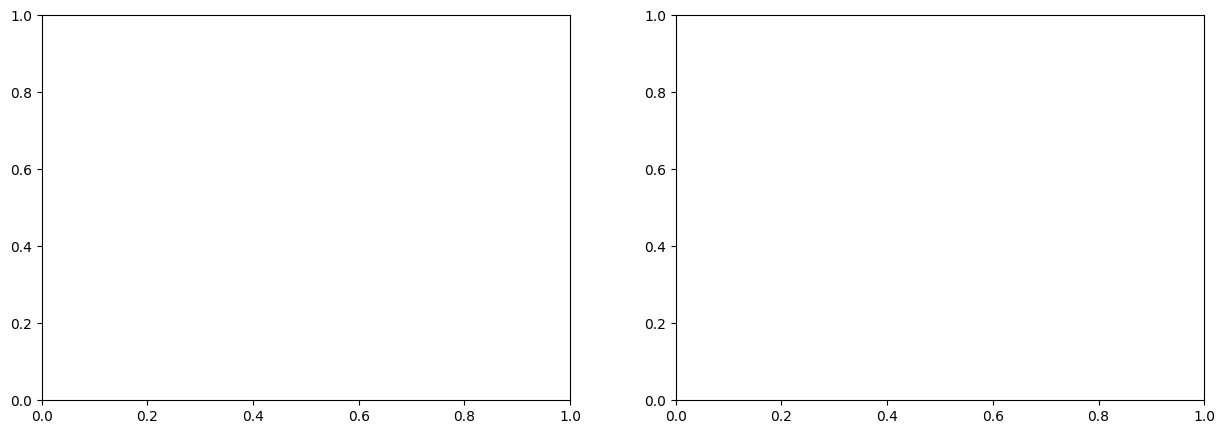

In [69]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,5))

# epoch_runs = [i+1 for i in range(epochs)]

# ax1.plot(epoch_runs,train_loss, label = 'Training Loss', marker = 'x')
# ax1.plot(epoch_runs,val_loss, label = 'Validiation Loss', marker = 'o')
# ax1.set(title = 'Training vs Validation Loss', xlabel = 'Epochs',ylabel = 'Loss')
# ax1.legend()

# ax2.plot(epoch_runs,train_acc, label = 'Training Accuracy', marker = 'x')
# ax2.plot(epoch_runs,val_acc, label = 'Validiation Accuracy', marker = 'o')
# ax2.set(title = 'Training vs Validation Accuracy', xlabel = 'Epochs',ylabel = 'Accuracy')
# ax2.legend()

# plt.show()

4. Model evaluation

In [70]:
score = model.evaluate(X_test,y_test_label)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9886 - loss: 0.0417


In [71]:
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

Test Loss: 0.0305
Test Accuracy: 0.9917


In [72]:
y_prob = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


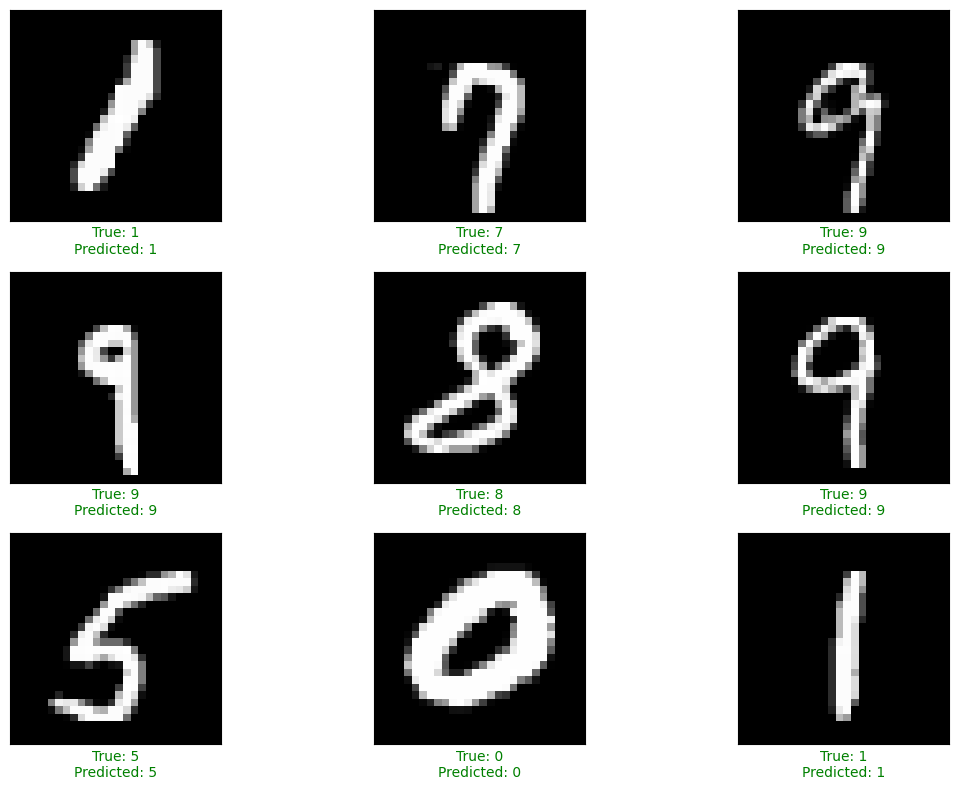

In [73]:
plot_image(X_test, y_test, y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted digit: 2


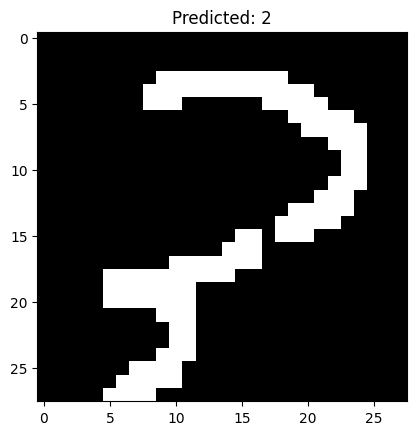

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted digit: 2


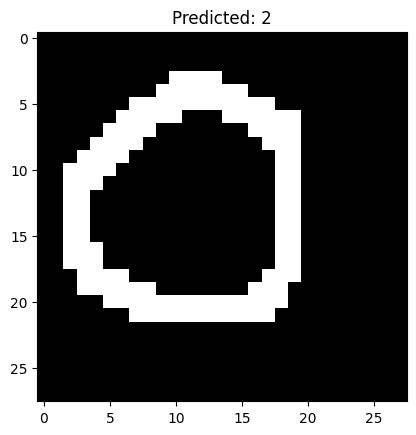

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted digit: 9


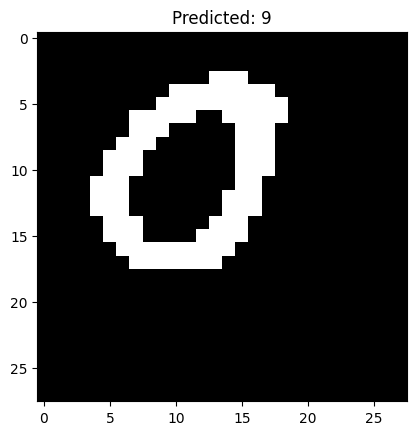

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted digit: 7


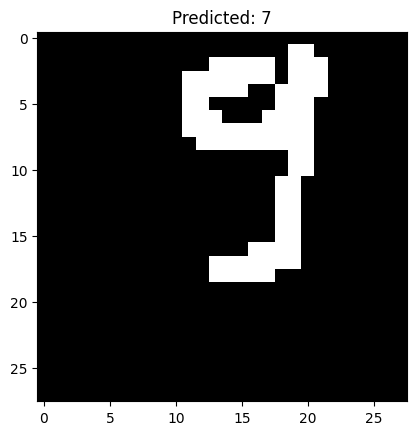

In [76]:



class App:
    def __init__(self, root):
        self.root = root
        self.root.title("Draw a digit (e.g., 8)")
        self.canvas = Canvas(self.root, width=200, height=200, bg="white")
        self.canvas.pack()

        self.image = PIL.Image.new("L", (28, 28), color=0)  # Create a 28x28 blank image
        self.draw = ImageDraw.Draw(self.image)

        # Bind events to handle drawing
        self.canvas.bind("<B1-Motion>", self.paint)

        # Add buttons for actions
        self.button_predict = Button(self.root, text="Predict", command=self.predict_digit)
        self.button_predict.pack()

        self.button_clear = Button(self.root, text="Clear", command=self.clear_canvas)
        self.button_clear.pack()

    def paint(self, event):
        """Draw on the canvas and save to the image"""
        x, y = event.x, event.y
        # Draw a small circle to simulate thicker drawing
        self.canvas.create_oval((x, y, x+8, y+8), fill="black", width=10)
        # Draw on the PIL image (scaling from 200x200 to 28x28)
        self.draw.ellipse((x * 28 / 200, y * 28 / 200, (x + 8) * 28 / 200, (y + 8) * 28 / 200), fill=255)

    def clear_canvas(self):
        """Clear the canvas and reset the drawing"""
        self.canvas.delete("all")
        self.image = PIL.Image.new("L", (28, 28), color=0)
        self.draw = ImageDraw.Draw(self.image)

    def predict_digit(self):
        """Predict the digit based on the drawing"""
        img_array = np.array(self.image) / 255.0  # Normalize image
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension (grayscale)

        # Predict using the model
        prediction = model.predict(img_array)
        predicted_digit = np.argmax(prediction)

        # Display result
        print(f"Predicted digit: {predicted_digit}")

        # Plot the image and show the prediction
        plt.imshow(self.image, cmap='gray')
        plt.title(f"Predicted: {predicted_digit}")
        plt.show()


root = Tk()
app = App(root)
root.mainloop()
